<a href="https://colab.research.google.com/github/ZygoOoade/conceptual_spaces/blob/main/Voronoi%20adjacent%20regions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

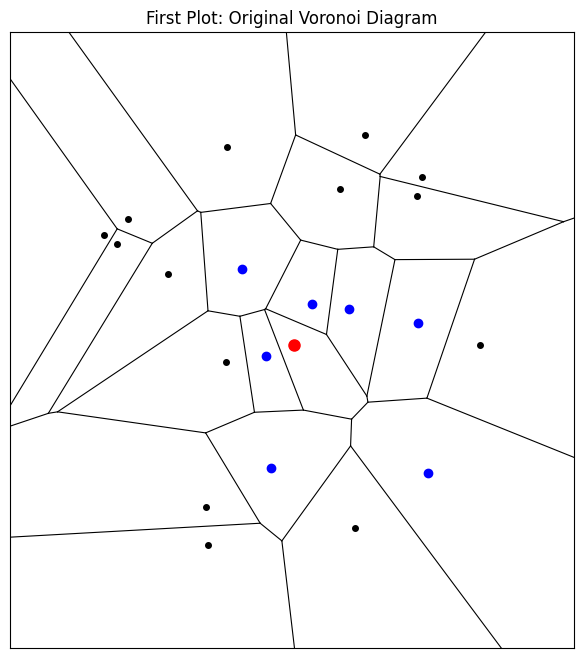

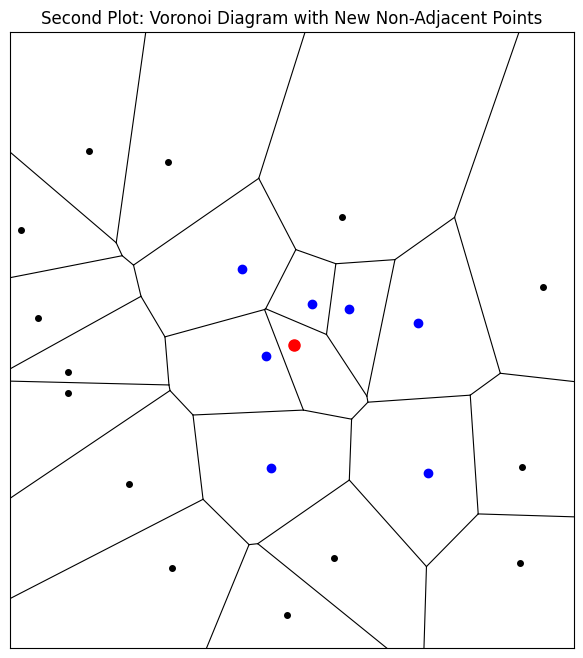

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, ConvexHull
from matplotlib.path import Path

#Plot the Voronoi diagram (without axis numbers or legend)
def plot_voronoi(points, central_point_idx, adj_indices, title, xlim, ylim):
    vor = Voronoi(points)

    fig, ax = plt.subplots(figsize=(8, 8))

    #Plot all points as black dots
    ax.plot(points[:, 0], points[:, 1], 'ko', markersize=4)

    #Highlight the central point in red
    ax.plot(points[central_point_idx, 0], points[central_point_idx, 1], 'ro', markersize=8)

    #Highlight adjacent points in blue
    ax.plot(points[adj_indices, 0], points[adj_indices, 1], 'bo', markersize=6)

    #Plot finite ridges (edges)
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):  # Finite ridge (no vertex at infinity)
            ax.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k-', lw=0.8)

    # Plot infinite ridges (edges)
    ptp_bound = points.ptp(axis=0)
    max_bound = ptp_bound.max()

    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            p1_idx, p2_idx = pointidx
            p1 = vor.points[p1_idx]
            p2 = vor.points[p2_idx]

            t = p2 - p1
            t = t / np.linalg.norm(t)
            n = np.array([-t[1], t[0]])

            finite_vertex_idx = simplex[simplex >= 0][0]
            finite_vertex = vor.vertices[finite_vertex_idx]

            midpoint = (p1 + p2) / 2
            direction = np.sign(np.dot(midpoint - points.mean(axis=0), n)) * n

            far_point = finite_vertex + direction * max_bound * 10

            ax.plot([finite_vertex[0], far_point[0]], [finite_vertex[1], far_point[1]], 'k-', lw=0.8)

    ax.set_aspect('equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Remove axis ticks
    ax.set_xticks([])  # Remove X-axis ticks
    ax.set_yticks([])  # Remove Y-axis ticks

    # Optionally, remove axis labels too (if not needed)
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title(title)
    plt.show()


# Generate the points
num_points = 21
R = 10

np.random.seed(1)
theta = np.random.uniform(0, 2 * np.pi, num_points)
r = R * np.sqrt(np.random.uniform(0, 1, num_points))

x = r * np.cos(theta)
y = r * np.sin(theta)
other_points = np.column_stack((x, y))

central_point = np.array([[0, 0]])
points = np.vstack((central_point, other_points))

vor = Voronoi(points)

ridge_points = vor.ridge_points

Adj_indices = []
for pair in ridge_points:
    if 0 in pair:
        neighbor = pair[0] if pair[1] == 0 else pair[1]
        Adj_indices.append(neighbor)

Adj_indices = np.unique(Adj_indices)
Adj_indices = Adj_indices[Adj_indices != 0]

Adj_P = points[Adj_indices.astype(int)]

hull_points = np.vstack((central_point, Adj_P))
hull = ConvexHull(hull_points)
hull_path = Path(hull_points[hull.vertices])

all_indices = np.arange(len(points))
Non_Adj_indices = np.setdiff1d(all_indices, np.concatenate(([0], Adj_indices)))
P_no_adj = points[Non_Adj_indices.astype(int)]
num_black = len(Non_Adj_indices)

all_x = points[:, 0]
all_y = points[:, 1]
x_range = all_x.max() - all_x.min()
y_range = all_y.max() - all_y.min()

expansion_factor = 1.5
x_min_initial = all_x.min() - ((expansion_factor - 1) * x_range / 2)
x_max_initial = all_x.max() + ((expansion_factor - 1) * x_range / 2)
y_min_initial = all_y.min() - ((expansion_factor - 1) * y_range / 2)
y_max_initial = all_y.max() + ((expansion_factor - 1) * y_range / 2)

xlim = (x_min_initial, x_max_initial)
ylim = (y_min_initial, y_max_initial)

# Plot the first Voronoi diagram
plot_voronoi(points, 0, Adj_indices.astype(int), 'First Plot: Original Voronoi Diagram', xlim, ylim)

# Generate new black points for the second plot
min_distance_threshold = 1.0
max_attempts = 1000
attempt = 0
new_black_points = []
combined_adj_points = np.vstack((central_point, Adj_P))

while len(new_black_points) < num_black and attempt < max_attempts * num_black:
    x_candidate = np.random.uniform(x_min_initial, x_max_initial)
    y_candidate = np.random.uniform(y_min_initial, y_max_initial)
    candidate_point = np.array([x_candidate, y_candidate])

    if not hull_path.contains_point(candidate_point):
        distances = np.linalg.norm(combined_adj_points - candidate_point, axis=1)
        if np.min(distances) >= min_distance_threshold:
            new_black_points.append(candidate_point)
    attempt += 1

new_black_points = np.array(new_black_points)
points2 = np.vstack((central_point, Adj_P, new_black_points))

central_pt_idx = 0
adj_pt_indices = np.arange(1, len(Adj_P) + 1)
black_pt_indices = np.arange(len(Adj_P) + 1, len(points2))

plot_voronoi(points2, central_pt_idx, adj_pt_indices, 'Second Plot: Voronoi Diagram with New Non-Adjacent Points', xlim, ylim)